In [426]:
import random
import json
import re

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from transformers import AutoTokenizer


In [427]:
from pathlib import Path
import os, sys
WORK_DIR = Path.cwd().parent.parent

sys.path.append(str(WORK_DIR))
print(WORK_DIR)


/home/lusha


In [428]:
from star_code.src.datasets import CVRRDataset, JudgeDataset
from star_code.src.prompt_formatters import OpenEndedPrompt, LlmAsJudgePrompt


# Eval on CVRR


**Parameters:**
- model: gemma3:4b-it-qat

## QA on generated graphs

System prompt

In [429]:
with open(WORK_DIR / 'cvrr/sys_prompt.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


# Video Question-Answering System Prompt

You are an AI assistant specialized in answering questions about videos based on their scene graph representations. Instead of receiving raw video data, you will be provided with structured scene graph information that captures the key visual and temporal elements of the video content.

## Input Format

You will receive two inputs:
1. **Question**: An open-ended question about the video content
2. **Scene Graph Representation**: A structured representation of the video containing:

### Scene Graph Structure
- **Objects**: Entities present in the video (people, animals, objects, etc.)
- **Attributes**: Properties of objects (color, size, position, state, etc.)
- **Relationships**: Spatial and semantic connections between objects
- **Temporal Information**: How objects and relationships change over time
- **Actions/Events**: Activities and interactions occurring in the video
- **Scene Context**: Location, setting, environmental details

### Examp

User prompt

In [430]:
with open(WORK_DIR / 'cvrr/user_prompt.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


# Question
{question}

# Spatio-Temporal Scene Graph Representation
{stsg}


Please analyze the provided scene graph representation and answer the question based on the visual and temporal information contained within it.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [431]:
user_prompt_formatter = OpenEndedPrompt(user_prompt)
qa_cvrr_dataset = CVRRDataset(
    qa_file_path=WORK_DIR/"cvrr/cvrr_val_updated.json",
    prompt_formatter=user_prompt_formatter,
    stsg_file_path=WORK_DIR/"cvrr/generated_stsg_cvrr_maxsample50.jsonl"
)



Dataset Statistics:
QA File: cvrr_val_updated.json
Number of QA samples: 2400
QA sample keys: dimension_name, subset, question_id, question, video_id, answer

STSG File: generated_stsg_cvrr_maxsample50.jsonl
Number of unique video IDs with STSG: 193



In [432]:
# example of entry
qa_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\npurple_cube ---- resting_on ---- white_table\nred_cone ---- resting_on ---- white_table\nyellow_sp

In [433]:
print(qa_cvrr_dataset[1]["prompt"])


# Question
Does the pink cube and shiny pink cube undergo any covering or stacking interactions with other objects?

# Spatio-Temporal Scene Graph Representation

Frame 0:


purple_cube ---- above ---- yellow_sphere
purple_cube ---- adjacent_to ---- green_cone
purple_cube ---- adjacent_to ---- red_cone
green_cone ---- to_the_left_of ---- purple_cube
red_cone ---- to_the_right_of ---- purple_cube
yellow_sphere ---- below ---- purple_cube
green_cone ---- positioned_near ---- purple_cube
red_cone ---- positioned_near ---- purple_cube
yellow_sphere ---- directly_under ---- purple_cube
purple_cube ---- supporting ---- yellow_sphere

Frame 1:

purple_cube ---- resting_on ---- white_table
red_cone ---- resting_on ---- white_table
yellow_sphere ---- resting_on ---- white_table
purple_cube ---- adjacent_to ---- red_cone
red_cone ---- adjacent_to ---- yellow_sphere
yellow_sphere ---- between ---- purple_cube and red_cone
purple_cube ---- to_the_right_of ---- red_cone
red_cone ---- to_the_left_of

## LLM as judge evaluation

System prompt

In [434]:
with open(WORK_DIR / 'cvrr/llm_as_judge_sys.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


You are an intelligent chatbot designed for evaluating the correctness of AI assistant predictions for
question-answer pairs.
Your task is to compare the predicted answer with the ground-truth answer and determine if the predicted
answer is correct or not. Here's how you can accomplish the task:
------
##INSTRUCTIONS:
- Focus on the correctness and accuracy of the predicted answer with the ground-truth.
- Consider predictions with less specific details as correct evaluation, unless such details are explicitly
asked in the question.



User prompt

In [435]:
with open(WORK_DIR / 'cvrr/llm_as_judge_user.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


Please evaluate the following video-based question-answer pair:
Question: {question}
Ground truth correct Answer: {gt_answer}
Predicted Answer: {prediction}
Provide your evaluation as a correct/incorrect prediction along with the score where the score is an
integer value between 0 (fully wrong) and 5 (fully correct). The middle score provides the percentage of
correctness.
Please generate the response in the form of a Python dictionary string with keys 'pred', 'score' and
'reason', where value of 'pred' is a string of 'correct' or 'incorrect', value of 'score' is in INTEGER, not STRING
and value of 'reason' should provide the reason behind the decision.
Only provide the Python dictionary string.
For example, your response should look like this: {{'pred': 'correct', 'score': 4, 'reason': reason}}.



In [436]:
judge_prompt_formatter = LlmAsJudgePrompt(user_prompt)
judge_cvrr_dataset = JudgeDataset(
    dataset=qa_cvrr_dataset,
    predictions_filepath=WORK_DIR/"cvrr/cvrr_qa_responses_maxsample50.jsonl",
    prompt_formatter=judge_prompt_formatter
)


In [437]:
judge_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\npurple_cube ---- resting_on ---- white_table\nred_cone ---- resting_on ---- white_table\nyellow_sp

In [438]:
print(judge_cvrr_dataset[0]['prompt'])


Please evaluate the following video-based question-answer pair:
Question: How many times is the golden hollow sphere gets covered by other objects?
Ground truth correct Answer: The golden hollow sphere is covered two times by other objects.
Predicted Answer: The golden hollow sphere (red_sphere) is covered by other objects in the following frames:

*   **Frame 0:** Covered by purple_cube.
*   **Frame 1:** Covered by red_cone.
*   **Frame 2:** Covered by red_cone.
*   **Frame 3:** Covered by green_sphere.
*   **Frame 4:** Covered by purple_cube.
*   **Frame 5:** Covered by purple_cube.
*   **Frame 6:** Covered by purple_cube.
*   **Frame 7:** Covered by purple_cube.
*   **Frame 8:** Covered by purple_cube.
*   **Frame 9:** Covered by purple_cube.
*   **Frame 10:** Covered by purple_cube.
*   **Frame 11:** Covered by purple_cube.

Therefore, the red_sphere is covered by purple_cube a total of 12 times across the provided frames.
Provide your evaluation as a correct/incorrect prediction a

## Answer loading and processing

### Loading the the Judge evaluation


In [439]:
# Load the scores for the wrong answers
predictions = []
with open(WORK_DIR / "cvrr/judge_eval_maxsample50.jsonl", 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 37.5+ KB


### Handle formatting issues

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [440]:

# Create mask for answers that follow JSON syntax
json_mask = judge_pred_df['response'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(judge_pred_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(judge_pred_df))*100:.2f}%")


Total answers: 2400
Answers following JSON template: 2385
Percentage following JSON template: 99.38%


In [441]:
judge_pred_df.loc[json_mask, 'response'] = \
    judge_pred_df.loc[json_mask, 'response'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

judge_pred_df.loc[~json_mask, 'response'] = ""
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [442]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u2018-\u201b]', '\'', regex=True)
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u201c\u201d]', '"', regex=True)


In [443]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': 'The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn\'t show any "destructive acts."'}

In [444]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*\})(.+)", 
            r"\1", 
            row['response']),
        axis=1
        )


In [445]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': 'The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn\'t show any "destructive acts."'}

In [446]:

    
# some times the model starts the answer with \" but then terminates it with \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\"(.*)\'\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )


In [447]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': 'The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn\'t show any "destructive acts."'}

In [448]:

    
# some times the model starts the answer with \' but then terminates it with \"
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\'(.*)\"\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )


In [449]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': 'The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn\'t show any "destructive acts."'}

In [450]:


    
# some times the model is enclosed by \' \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(?<=\'reason\':)\s+\'(.*)\'\s*(?=})", 
            lambda matchobj: "\"" + matchobj.group(1)+ "\"", 
            row['response']),
        axis=1
        )


In [451]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': 'The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn\'t show any "destructive acts."'}

In [452]:
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(\'reason\':\s*\")(.*\".*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', '\''), 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [453]:
eval(judge_pred_df.iloc[2113]["response"])


{'pred': 'correct',
 'score': 5,
 'reason': "The predicted answer accurately reflects the information (or lack thereof) present in the scene graph. It correctly states that there is no depiction of a man wearing a hat and that the scene graph doesn't show any 'destructive acts.'"}

In [454]:
judge_pred_df = judge_pred_df.loc[json_mask]


### Extract answers

In [455]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,correct,5,The predicted answer accurately identifies eac...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the g...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The ground truth answer states that two cones ...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,2,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer focuses on a series of un...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,1,The ground truth states the woman is performin...


In [456]:
judge_pred_df.shape


(2385, 3)

### Filtering-out answers associated to few *extracted* frames

In [457]:
GEN_STSG_50 = WORK_DIR / "cvrr/generated_stsg_cvrr_maxsample50.jsonl"


In [458]:
stsg_data = []
with open(GEN_STSG_50, 'r') as f:
    stsg_data = [json.loads(line) for line in f]


In [459]:
def get_highest_frame_number(text):
    # Regular expression to match "Frame dd:" pattern where dd is one or more digits
    frame_pattern = r'Frame\s+(\d+):'
    
    # Find all frame numbers
    matches = re.findall(frame_pattern, text)
    
    if not matches:
        return None
    
    # Convert to integers and return the maximum
    frame_numbers = [int(match) for match in matches]
    return max(frame_numbers)


In [460]:
frame_count = {}
for item in stsg_data:
    frame_count[item['video_id']] = get_highest_frame_number(item['stsg'])
    
sum([v for _, v in frame_count.items()])/len(frame_count)


20.06217616580311

In [461]:
frame_count_se = pd.Series(frame_count)
frame_count_se


partial_actions_126                                           2
multiple_actions_in_a_single_video_69                        32
multiple_actions_in_a_single_video_78                        46
multiple_actions_in_a_single_video_79                        31
multiple_actions_in_a_single_video_61                        30
                                                             ..
interpretation_of_social_context_37                           4
non_existent_actions_with_existent_scene_depictions_51        1
non_existent_actions_with_non_existent_scene_depictions_0     0
non_existent_actions_with_non_existent_scene_depictions_6     0
partial_actions_122                                           1
Length: 193, dtype: int64

In [462]:
frame_count_se.value_counts()[0]


np.int64(3)

In [463]:
frame_count_se.describe()


count    193.000000
mean      20.062176
std       14.713453
min        0.000000
25%        9.000000
50%       15.000000
75%       30.000000
max       49.000000
dtype: float64

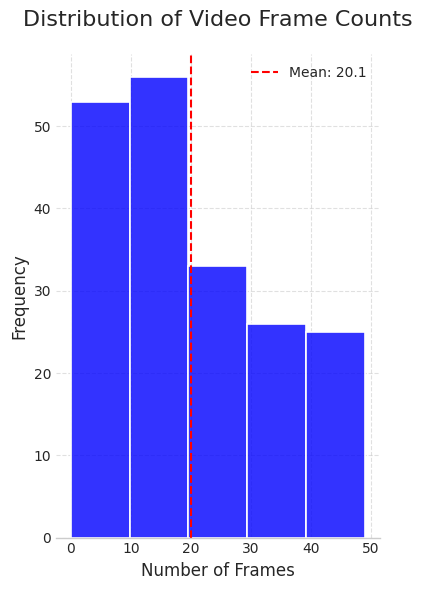

In [464]:
# Set style for better aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(4, 6))

# Create the histogram with improved settings
ax = sns.histplot(
    frame_count_se, 
    bins=5,        # Adds a smoothed density curve
    color="Blue",    # Custom color
    edgecolor="white",  # Adds clean edges to bars
    linewidth=1.2,      # Makes edges slightly thicker
    alpha=0.8,          # Adds slight transparency
)

# Add titles and labels
plt.title(
    "Distribution of Video Frame Counts", 
    fontsize=16, 
    pad=20,           # Adds padding above the title
)
plt.xlabel("Number of Frames", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Customize grid and spines for a cleaner look
ax.grid(True, linestyle='--', alpha=0.6)
sns.despine(left=True)  # Removes the left spine for minimalism

# Add a vertical line for mean/median if useful
mean_val = frame_count_se.mean()
plt.axvline(
    mean_val, 
    color="red", 
    linestyle="--", 
    linewidth=1.5, 
    label=f"Mean: {mean_val:.1f}",
)
plt.legend()

plt.tight_layout()  # Prevents label cutoff
plt.show()


In [465]:
min_frames = 5

print(f"Number of videos with at least {min_frames} frames: {(frame_count_se > 5).sum()}")


Number of videos with at least 5 frames: 162


### Link video information and n_frames to judge_pred_df

In [466]:
# Need to reload the qa_cvrr_dataset, because is modified by judge_cvrr_dataset when loaded
with open(WORK_DIR / 'cvrr/user_prompt.txt', 'r') as f:
    user_prompt = f.read()
    
user_prompt_formatter = OpenEndedPrompt(user_prompt)
qa_cvrr_dataset = CVRRDataset(
    qa_file_path=WORK_DIR/"cvrr/cvrr_val_updated.json",
    prompt_formatter=user_prompt_formatter,
    stsg_file_path=WORK_DIR/"cvrr/generated_stsg_cvrr_maxsample50.jsonl"
)

qa_cvrr_dataset_df = pd.DataFrame([i for i in qa_cvrr_dataset])
qa_cvrr_dataset_df.set_index('question_id', inplace=True)
qa_cvrr_dataset_df.info()



Dataset Statistics:
QA File: cvrr_val_updated.json
Number of QA samples: 2400
QA sample keys: dimension_name, subset, question_id, question, video_id, answer

STSG File: generated_stsg_cvrr_maxsample50.jsonl
Number of unique video IDs with STSG: 193

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dimension_name  2400 non-null   object
 1   subset          2400 non-null   object
 2   question        2400 non-null   object
 3   video_id        2400 non-null   object
 4   answer          2400 non-null   object
 5   stsg            2087 non-null   object
 6   qid             2400 non-null   object
 7   prompt          2400 non-null   object
dtypes: object(8)
memory usage: 168.8+ KB


In [467]:
judge_cvrr_dataset_df = pd.DataFrame([i for i in judge_cvrr_dataset])
judge_cvrr_dataset_df.set_index('question_id', inplace=True)
judge_cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dimension_name  2400 non-null   object
 1   subset          2400 non-null   object
 2   question        2400 non-null   object
 3   video_id        2400 non-null   object
 4   answer          2400 non-null   object
 5   stsg            2087 non-null   object
 6   qid             2400 non-null   object
 7   prompt          2400 non-null   object
 8   gt_answer       2400 non-null   object
 9   response        2400 non-null   object
dtypes: object(10)
memory usage: 206.2+ KB


In [468]:
print(qa_cvrr_dataset_df.iloc[0]['prompt'])


# Question
How many times is the golden hollow sphere gets covered by other objects?

# Spatio-Temporal Scene Graph Representation

Frame 0:


purple_cube ---- above ---- yellow_sphere
purple_cube ---- adjacent_to ---- green_cone
purple_cube ---- adjacent_to ---- red_cone
green_cone ---- to_the_left_of ---- purple_cube
red_cone ---- to_the_right_of ---- purple_cube
yellow_sphere ---- below ---- purple_cube
green_cone ---- positioned_near ---- purple_cube
red_cone ---- positioned_near ---- purple_cube
yellow_sphere ---- directly_under ---- purple_cube
purple_cube ---- supporting ---- yellow_sphere

Frame 1:

purple_cube ---- resting_on ---- white_table
red_cone ---- resting_on ---- white_table
yellow_sphere ---- resting_on ---- white_table
purple_cube ---- adjacent_to ---- red_cone
red_cone ---- adjacent_to ---- yellow_sphere
yellow_sphere ---- between ---- purple_cube and red_cone
purple_cube ---- to_the_right_of ---- red_cone
red_cone ---- to_the_left_of ---- yellow_sphere
yellow_sphe

In [469]:
print(judge_cvrr_dataset_df.iloc[0]['prompt'])


Please evaluate the following video-based question-answer pair:
Question: How many times is the golden hollow sphere gets covered by other objects?
Ground truth correct Answer: The golden hollow sphere is covered two times by other objects.
Predicted Answer: The golden hollow sphere (red_sphere) is covered by other objects in the following frames:

*   **Frame 0:** Covered by purple_cube.
*   **Frame 1:** Covered by red_cone.
*   **Frame 2:** Covered by red_cone.
*   **Frame 3:** Covered by green_sphere.
*   **Frame 4:** Covered by purple_cube.
*   **Frame 5:** Covered by purple_cube.
*   **Frame 6:** Covered by purple_cube.
*   **Frame 7:** Covered by purple_cube.
*   **Frame 8:** Covered by purple_cube.
*   **Frame 9:** Covered by purple_cube.
*   **Frame 10:** Covered by purple_cube.
*   **Frame 11:** Covered by purple_cube.

Therefore, the red_sphere is covered by purple_cube a total of 12 times across the provided frames.
Provide your evaluation as a correct/incorrect prediction a

In [470]:
frame_count_se.rename('n_frames').reset_index()


,index,n_frames
0,partial_actions_126,2
1,multiple_actions_in_a_single_video_69,32
2,multiple_actions_in_a_single_video_78,46
3,multiple_actions_in_a_single_video_79,31
4,multiple_actions_in_a_single_video_61,30
...,...,...
188,interpretation_of_social_context_37,4
189,non_existent_actions_with_existent_scene_depic...,1
190,non_existent_actions_with_non_existent_scene_d...,0
191,non_existent_actions_with_non_existent_scene_d...,0


In [471]:

frame_count_df = frame_count_se.reset_index()
frame_count_df.columns = ['video_id', 'n_frames']  # Rename columns if needed

original_index = judge_cvrr_dataset_df.index
judge_cvrr_dataset_df = judge_cvrr_dataset_df.merge(
    frame_count_df,
    on='video_id', 
    how='left'
)

# need to 
judge_cvrr_dataset_df.index = original_index
judge_cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dimension_name  2400 non-null   object 
 1   subset          2400 non-null   object 
 2   question        2400 non-null   object 
 3   video_id        2400 non-null   object 
 4   answer          2400 non-null   object 
 5   stsg            2087 non-null   object 
 6   qid             2400 non-null   object 
 7   prompt          2400 non-null   object 
 8   gt_answer       2400 non-null   object 
 9   response        2400 non-null   object 
 10  n_frames        2087 non-null   float64
dtypes: float64(1), object(10)
memory usage: 225.0+ KB


In [472]:
original_index = qa_cvrr_dataset_df.index
qa_cvrr_dataset_df = qa_cvrr_dataset_df.merge(
    frame_count_df,
    on='video_id', 
    how='left')

# need to 
qa_cvrr_dataset_df.index = original_index
qa_cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dimension_name  2400 non-null   object 
 1   subset          2400 non-null   object 
 2   question        2400 non-null   object 
 3   video_id        2400 non-null   object 
 4   answer          2400 non-null   object 
 5   stsg            2087 non-null   object 
 6   qid             2400 non-null   object 
 7   prompt          2400 non-null   object 
 8   n_frames        2087 non-null   float64
dtypes: float64(1), object(8)
memory usage: 187.5+ KB


In [473]:
judge_cvrr_dataset_df['n_frames'].isna().sum()


np.int64(313)

In [474]:
judge_pred_df = judge_pred_df[judge_pred_df['n_frames'].notna()]
judge_pred_df.info()


KeyError: 'n_frames'

In [279]:
qa_cvrr_dataset_df = qa_cvrr_dataset_df.loc[judge_pred_df.index]
qa_cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2072 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dimension_name  2072 non-null   object 
 1   subset          2072 non-null   object 
 2   question        2072 non-null   object 
 3   video_id        2072 non-null   object 
 4   answer          2072 non-null   object 
 5   stsg            2072 non-null   object 
 6   qid             2072 non-null   object 
 7   prompt          2072 non-null   object 
 8   n_frames        2072 non-null   float64
dtypes: float64(1), object(8)
memory usage: 161.9+ KB


In [280]:
judge_pred_df[['video_id', 'n_frames']] = judge_cvrr_dataset_df[['video_id', 'n_frames']]
judge_pred_df['judge_prompt'] = judge_cvrr_dataset_df['prompt']
judge_pred_df['graph_question_prompt'] = qa_cvrr_dataset_df['prompt']
judge_pred_df[judge_pred_df['n_frames'] > 30].shape


(454, 7)

## Metric values

In [281]:
min_frames = 5
pred_percentages = judge_pred_df[judge_pred_df['n_frames'] > min_frames]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  64.89%
correct   :  35.11%
------------------------------


In [282]:
n_frames = [i for i in range(0, 31, 5)]
data_points_size = []
acc_vals = []

for frames in n_frames:
    mask = judge_pred_df['n_frames'] > frames
    data_points_size.append(mask.sum())
    
    pred_percentages = judge_pred_df[mask]['pred'].value_counts(normalize=True)
    acc_vals.append(pred_percentages['correct'])


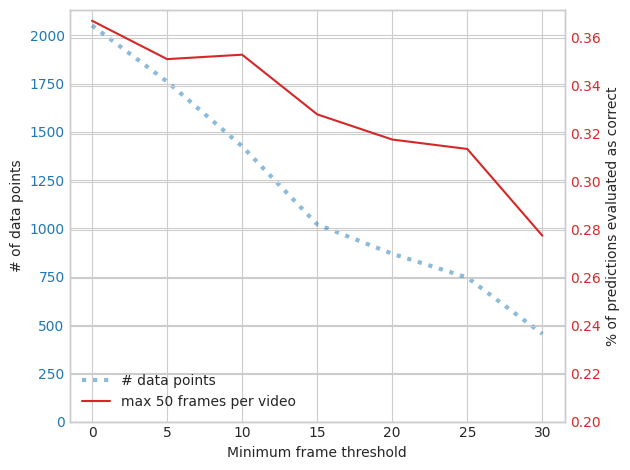

In [283]:
_, ax1 = plt.subplots()

# Beautiful seaborn-inspired colors
fst_color = 'tab:blue'    # Deep blue - very pleasing to the eye
snd_color = 'tab:red'  # Deep magenta/purple - great contrast

ax1.set_xlabel("Minimum frame threshold")
ax1.set_ylabel("# of data points")
line0 = ax1.plot(n_frames, data_points_size, color=fst_color, label='# data points',  linestyle=':', linewidth=3, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=fst_color)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.set_ylabel("% of predictions evaluated as correct")
line1 = ax2.plot(n_frames, acc_vals, color=snd_color, label="max 50 frames per video")
ax2.tick_params(axis='y', labelcolor=snd_color)
ax2.set_ylim(bottom=.2)

# Add legend to distinguish the two lines on the secondary axis
lines = line0 + line1
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='lower left')

plt.tight_layout()
plt.show()


### There's correlation between answer length and evaluation?

In [ ]:
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
    'google/gemma-3-4b-it', 
    token=hugg_key)

token_len_df = pd.DataFrame(index=judge_pred_df.index)
token_len_df['ans_len'] = judge_pred_df['reason'].apply(lambda x: len(tokenizer.encode(x)))
token_len_df['judge_prompt'] = judge_pred_df['judge_prompt'].apply(lambda x: len(tokenizer.encode(x)))
token_len_df['question_len'] = judge_pred_df['graph_question_prompt'].apply(lambda x: len(tokenizer.encode(x)))

# add prediction for analysis
token_len_df['pred'] = judge_pred_df['pred']
token_len_df['n_frames'] = judge_pred_df['n_frames']
token_len_df


,ans_len,judge_prompt,question_len,pred,n_frames
id,,,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,52,419,1866,correct,11.0
b27163c5-d341-475b-8517-54809872081a,44,345,1870,correct,11.0
9bce3140-e8e8-49dd-8574-5e961326fb16,43,394,1869,incorrect,11.0
b8df9fbe-07db-46ab-ba17-3713c1632dbd,45,328,1870,incorrect,11.0
01c30c62-f489-4246-af18-b7b538b4cb9d,37,376,1863,correct,11.0
...,...,...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,67,411,1411,incorrect,8.0
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,62,496,1405,incorrect,8.0
247a493d-0d24-4f1b-bbf6-b03e8973b544,39,319,1418,incorrect,8.0


In [ ]:
token_len_df.describe()


,ans_len,judge_prompt,question_len,n_frames
count,2072.000000,2072.000000,2072.000000,2072.000000
mean,60.970077,411.832046,3527.537645,19.652027
std,16.527988,164.966478,2465.351369,14.072073
min,23.000000,209.000000,171.000000,0.000000
25%,49.000000,326.000000,1597.000000,9.000000
50%,59.000000,376.000000,2784.000000,15.000000
75%,70.250000,459.000000,5367.250000,30.000000
max,134.000000,2374.000000,19510.000000,49.000000


Text(0.5, 1.0, 'Relationship between Number of Frames and Question Length')

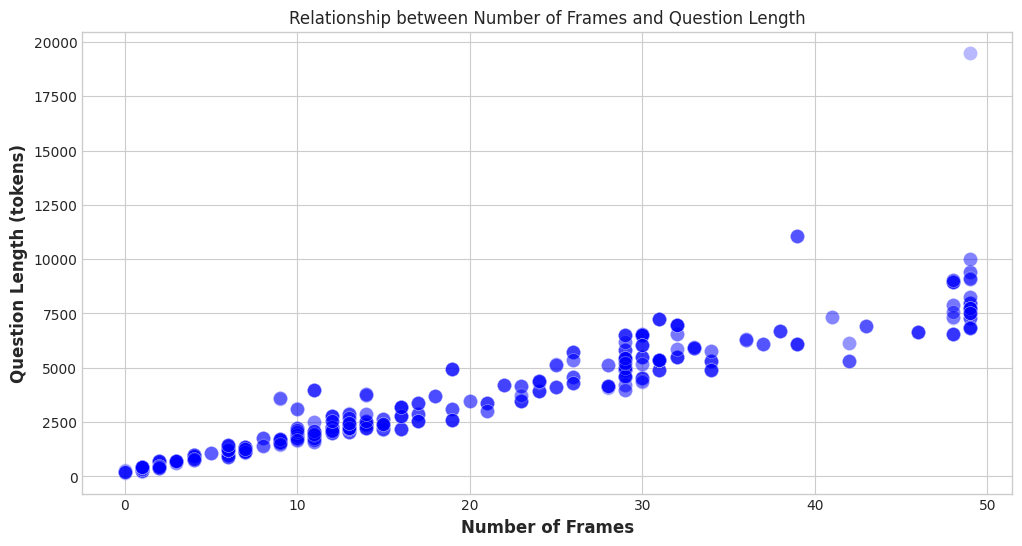

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Your original scatter plot
x = judge_pred_df['n_frames']
y = token_len_df['question_len']

scatter = ax.scatter(x, y, 
    alpha=0.1,         
    s=100,              
    c='Blue',     
    edgecolors='white',
    linewidth=0.4,
)

ax.set_xlabel('Number of Frames', fontsize=12, fontweight='bold')
ax.set_ylabel('Question Length (tokens)', fontsize=12, fontweight='bold')
ax.set_title('Relationship between Number of Frames and Question Length')


Text(0.5, 1.0, 'Relationship between Q and A lengths')

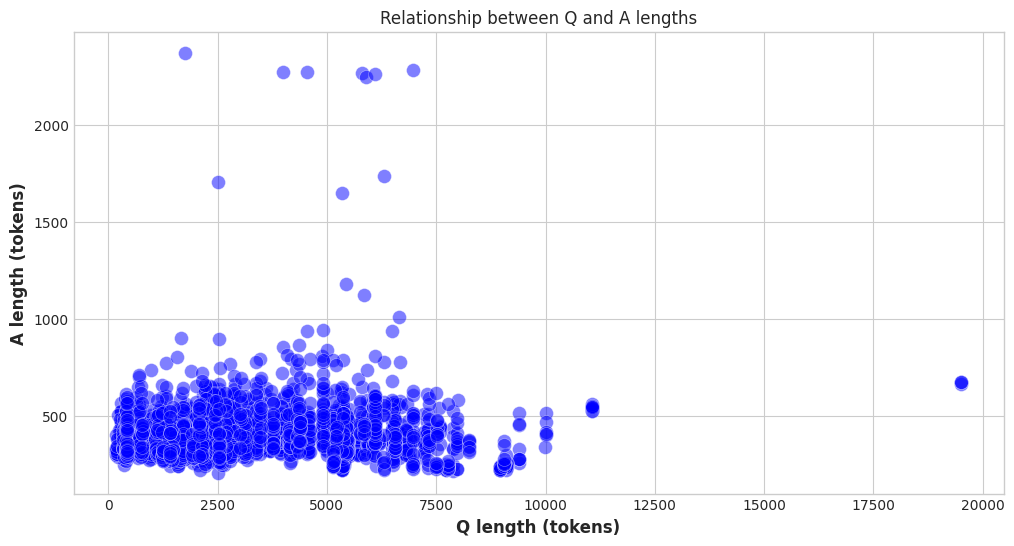

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Your original scatter plot
x = token_len_df['question_len']
y = token_len_df['judge_prompt']

scatter = ax.scatter(x, y, 
    alpha=0.5,         
    s=100,              
    c='Blue',     
    edgecolors='white',
    linewidth=0.4,
)

ax.set_xlabel('Q length (tokens)', fontsize=12, fontweight='bold')
ax.set_ylabel('A length (tokens)', fontsize=12, fontweight='bold')
ax.set_title('Relationship between Q and A lengths')


Text(0.5, 1.0, 'Density Relationship Q and A lengths')

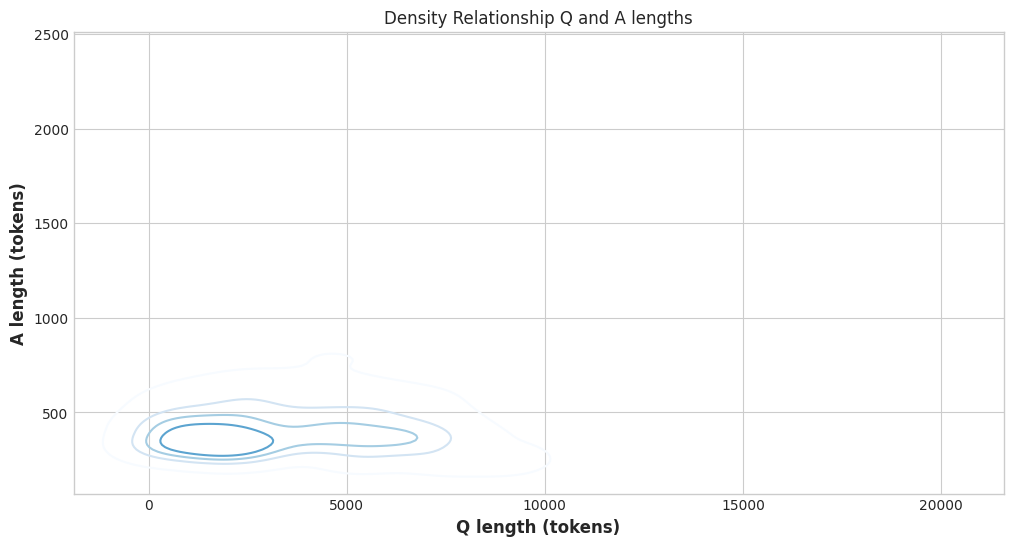

In [349]:
fig, ax = plt.subplots(figsize=(12, 6))

# Contour plot
sns.kdeplot(data=token_len_df, 
            x='question_len', 
            y='judge_prompt',
            levels=5,       # number of contour levels
            cmap='Blues',
            ax=ax)

ax.set_xlabel('Q length (tokens)', fontsize=12, fontweight='bold')
ax.set_ylabel('A length (tokens)', fontsize=12, fontweight='bold')
ax.set_title('Density Relationship Q and A lengths')


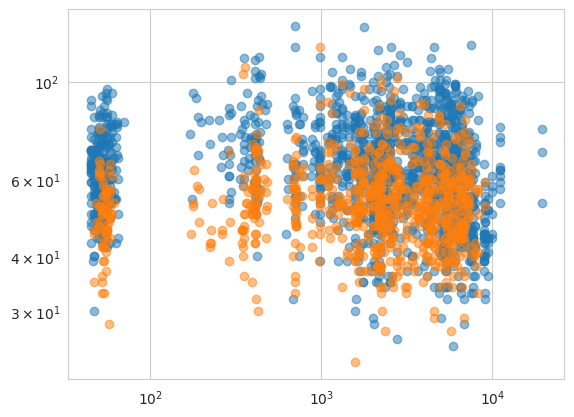

In [197]:
mask = token_len_df['pred'] == 'correct'
plt.scatter(
    token_len_df[~mask]['question_len'],
    token_len_df[~mask]['ans_len'],
    alpha=.5)
plt.scatter(
    token_len_df[mask]['question_len'],
    token_len_df[mask]['ans_len'],
    alpha=.5)

plt.xscale('log')
plt.yscale('log')


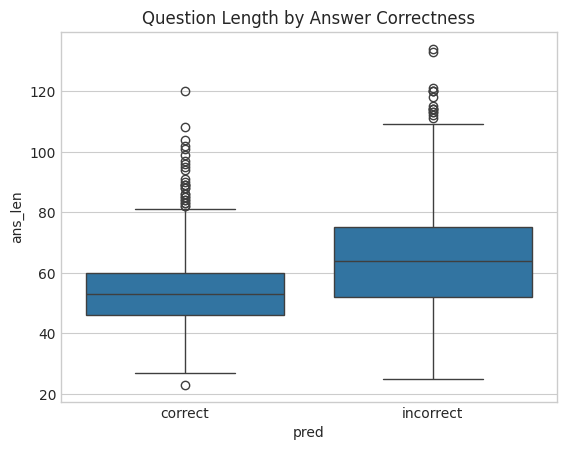

In [ ]:
sns.boxplot(x='pred', y='ans_len', data=token_len_df)
plt.title("Question Length by Answer Correctness")
plt.show()


In [514]:
import pandas as pd
import numpy as np

def remove_outliers(df, column, method='iqr', factor=1.5, by_group=None):
    original_count = len(df)
    
    if by_group is None:
        clean_df, stats = _remove_outliers_single(df, column, method, factor)
        stats['by_group'] = False
    else:
        clean_dfs = []
        group_stats = {}
        
        for group_name, group_df in df.groupby(by_group):
            clean_group, group_stat = _remove_outliers_single(group_df, column, method, factor)
            clean_dfs.append(clean_group)
            group_stats[group_name] = group_stat
        
        clean_df = pd.concat(clean_dfs, ignore_index=True)
        stats = {
            'by_group': True,
            'group_column': by_group,
            'group_stats': group_stats,
            'total_original': original_count,
            'total_remaining': len(clean_df),
            'total_removed': original_count - len(clean_df),
            'removal_percentage': ((original_count - len(clean_df)) / original_count) * 100
        }
    
    return clean_df, stats

def _remove_outliers_single(df, column, method, factor):
    data = df[column].copy()
    original_count = len(df)
    
    if method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        mask = (data >= lower_bound) & (data <= upper_bound)
        
    elif method == 'zscore':
        z_scores = np.abs((data - data.mean()) / data.std())
        mask = z_scores <= factor
        
    elif method == 'modified_zscore':
        median = data.median()
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        mask = np.abs(modified_z_scores) <= factor
    
    clean_df = df[mask].copy()
    
    stats = {
        'original_count': original_count,
        'remaining_count': len(clean_df),
        'removed_count': original_count - len(clean_df),
        'removal_percentage': ((original_count - len(clean_df)) / original_count) * 100,
        'method': method,
        'factor': factor
    }
    
    if method == 'iqr':
        stats.update({
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
    
    return clean_df, stats

# Usage examples:
clean_df, stats = remove_outliers(token_len_df, 'judge_prompt')
# clean_df, stats = remove_outliers(token_len_df, 'question_len', by_group='pred')
# clean_df, stats = remove_outliers(token_len_df, 'question_len', method='zscore', factor=3.0)
stats


{'original_count': 2072,
 'remaining_count': 2000,
 'removed_count': 72,
 'removal_percentage': 3.474903474903475,
 'method': 'iqr',
 'factor': 1.5,
 'lower_bound': np.float64(126.5),
 'upper_bound': np.float64(658.5),
 'Q1': np.float64(326.0),
 'Q3': np.float64(459.0),
 'IQR': np.float64(133.0),
 'by_group': False}

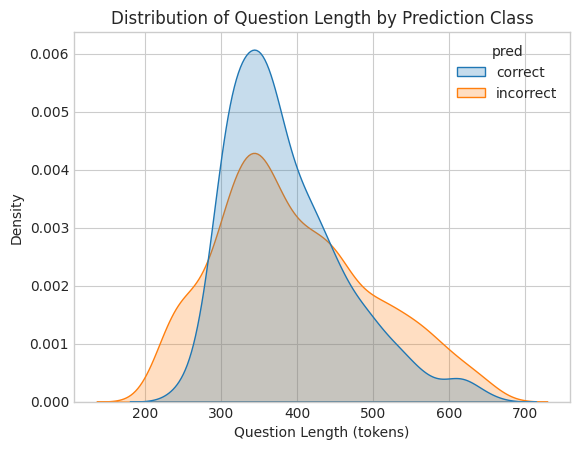

In [515]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the KDE plot
sns.kdeplot(
    data=clean_df,
    x='judge_prompt', 
    hue='pred',
    fill=True,
    common_norm=False,
)

# Add title and labels
plt.title('Distribution of Question Length by Prediction Class')
plt.xlabel('Question Length (tokens)')  # or 'words' if appropriate
plt.ylabel('Density')

# Show the plot
plt.show()


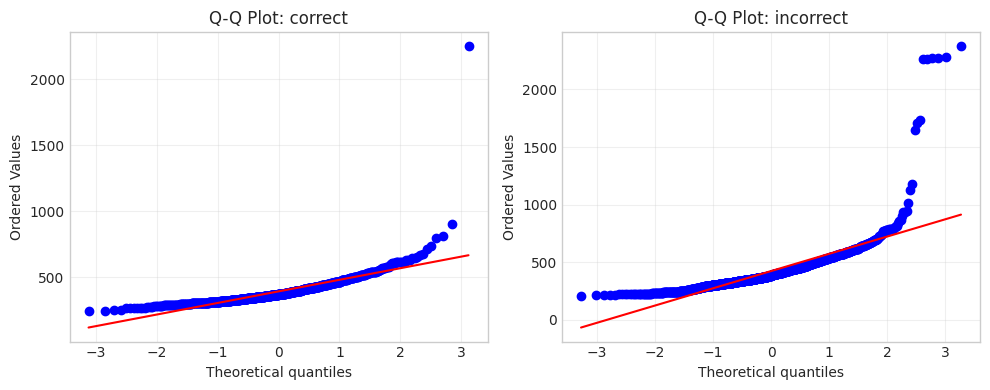

In [516]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create subplots for each category
categories = token_len_df['pred'].unique()
fig, axes = plt.subplots(1, len(categories), figsize=(5*len(categories), 4))

if len(categories) == 1:
    axes = [axes]  # Handle single subplot case

for i, category in enumerate(categories):
    # Filter data for this category
    data = token_len_df[token_len_df['pred'] == category]['judge_prompt']
    
    # Create Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {category}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Stat analysis

In [517]:
# Merge the two DataFrames if needed
df = pd.DataFrame({
    'attr': clean_df['judge_prompt'],
    'prediction': clean_df['pred']
})


Text(0.5, 1.0, 'Distribution of Question Length by Prediction Class')

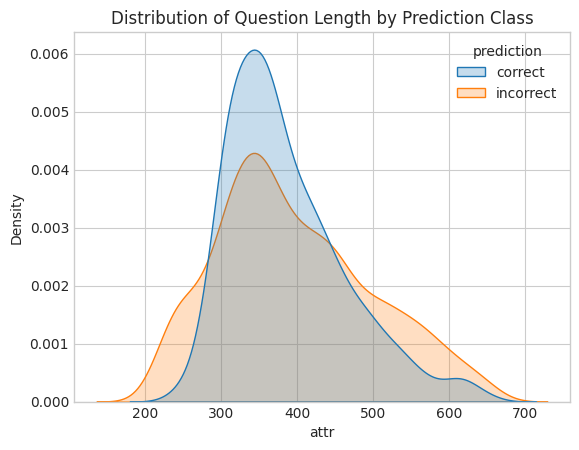

In [518]:
# Create the KDE plot
sns.kdeplot(
    data=df,
    x='attr', 
    hue='prediction',
    fill=True,
    common_norm=False,
)

# Add title and labels
plt.title('Distribution of Question Length by Prediction Class')


Text(0.5, 1.0, 'Distribution of Question Length by Prediction Class')

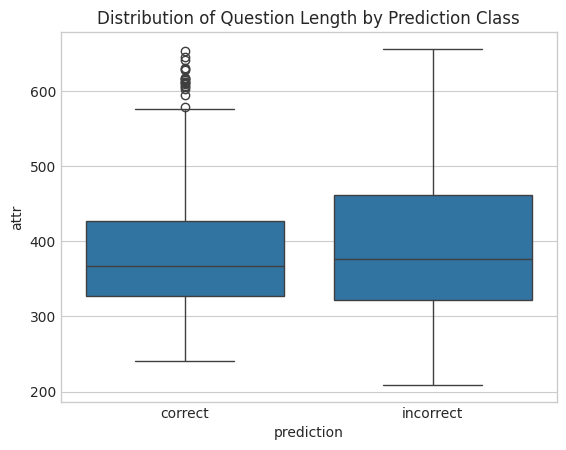

In [519]:
# Create the KDE plot
sns.boxplot(
    data=df,
    y='attr', 
    x='prediction',
)

# Add title and labels
plt.title('Distribution of Question Length by Prediction Class')


In [520]:
# Group statistics
correct_preds = df[df['prediction'] == 'correct']['attr']
incorrect_preds = df[df['prediction'] == 'incorrect']['attr']
correct_stats = correct_preds.describe()
incorrect_stats = incorrect_preds.describe()

print("Correct answers - Question length stats:")
print(correct_stats)
print("\nIncorrect answers - Question length stats:")
print(incorrect_stats)


Correct answers - Question length stats:
count    755.000000
mean     385.582781
std       77.472795
min      241.000000
25%      327.500000
50%      367.000000
75%      427.000000
max      653.000000
Name: attr, dtype: float64

Incorrect answers - Question length stats:
count    1245.000000
mean      396.351807
std       101.853916
min       209.000000
25%       322.000000
50%       377.000000
75%       462.000000
max       656.000000
Name: attr, dtype: float64


In [521]:
# Check normality for both groups
_, p_correct = stats.shapiro(correct_preds)
_, p_incorrect = stats.shapiro(incorrect_preds)

print(f"Normality p-values: Correct={p_correct:.3f}, Incorrect={p_incorrect:.3f}")


Normality p-values: Correct=0.000, Incorrect=0.000


Reject the null-hypothesis of the data being normally distributed

In [522]:
_, p_levene = stats.levene(
    correct_preds,
    incorrect_preds
)
print(f"Equal variances p-value: {p_levene:.3f}")


Equal variances p-value: 0.000


In [523]:
t_stat, p_value = stats.ttest_ind(
    correct_preds,
    incorrect_preds,
    equal_var=(p_levene > 0.05)  # Use Levene's result (Welch's test if equal_var=False)
)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")


t-statistic: -2.669, p-value: 0.0077


In [524]:
def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    pooled_std = np.sqrt((group1.std()**2 + group2.std()**2) / 2)
    return diff / pooled_std

d = cohens_d(
    correct_preds,
    incorrect_preds
)
print(f"Cohen's d: {d:.3f}")


Cohen's d: -0.119


In [525]:
u_stat, p_value = stats.mannwhitneyu(
    correct_preds,
    incorrect_preds,
    alternative='two-sided'
)
print(f"U-statistic: {u_stat}, p-value: {p_value:.4f}")


U-statistic: 447736.0, p-value: 0.0755


In [504]:
n1 = len(correct_preds)
n2 = len(incorrect_preds)
r_biserial = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-biserial correlation (Effect size): {r_biserial:.3f}")

print("""
Interpretation:
- rank_biserial = 0: No effect.
- rank_biserial = ±0.3: Small effect.
- rank_biserial = ±0.5: Medium effect.
""")


Rank-biserial correlation (Effect size): -0.013

Interpretation:
- rank_biserial = 0: No effect.
- rank_biserial = ±0.3: Small effect.
- rank_biserial = ±0.5: Medium effect.



In [505]:
point_biserial = stats.pointbiserialr(df['attr'], df['prediction'] == 'correct')

print(f"Point-biserial correlation: {point_biserial.correlation:.3f}")
print(f"p-value: {point_biserial.pvalue:.4f}")


Point-biserial correlation: -0.057
p-value: 0.0054


,ans_len,judge_prompt,question_len,n_frames
count,2072.000000,2072.000000,2072.000000,2072.000000
mean,60.970077,411.832046,3527.537645,19.652027
std,16.527988,164.966478,2465.351369,14.072073
min,23.000000,209.000000,171.000000,0.000000
25%,49.000000,326.000000,1597.000000,9.000000
50%,59.000000,376.000000,2784.000000,15.000000
75%,70.250000,459.000000,5367.250000,30.000000
max,134.000000,2374.000000,19510.000000,49.000000


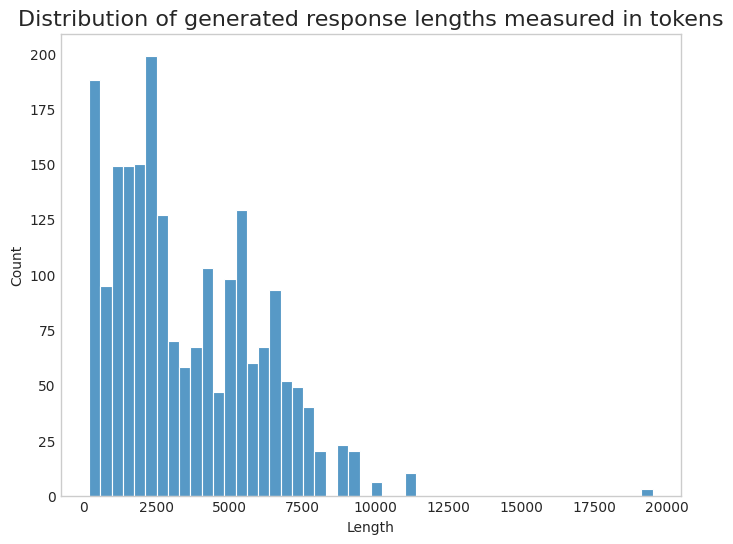

In [506]:
plt.figure(figsize=(8, 6))
sns.histplot(token_len_df['question_len'], bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.grid(False)
plt.xlabel("Length")
plt.ylabel("Count")

token_len_df.describe()


### Manual inspection

Let's analyze some of the answers

In [507]:
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,correct,5,The predicted answer accurately identifies eac...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the g...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The ground truth answer states that two cones ...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,2,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer focuses on a series of un...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,1,The ground truth states the woman is performin...


In [508]:
judged_correct_mask = (judge_pred_df['pred'] == 'correct')
idx = "8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6"


print(f"Index: {idx}")
print(f"Question: {cvrr_dataset_df.loc[idx]['question']}")
print(f"\nGround truth answer:\n{cvrr_dataset_df.loc[idx]['answer']}")
print(f"\nLLM prediction:\n{ans_df.loc[idx]['text']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: 8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6


NameError: name 'cvrr_dataset_df' is not defined

### Distribution of confidence score

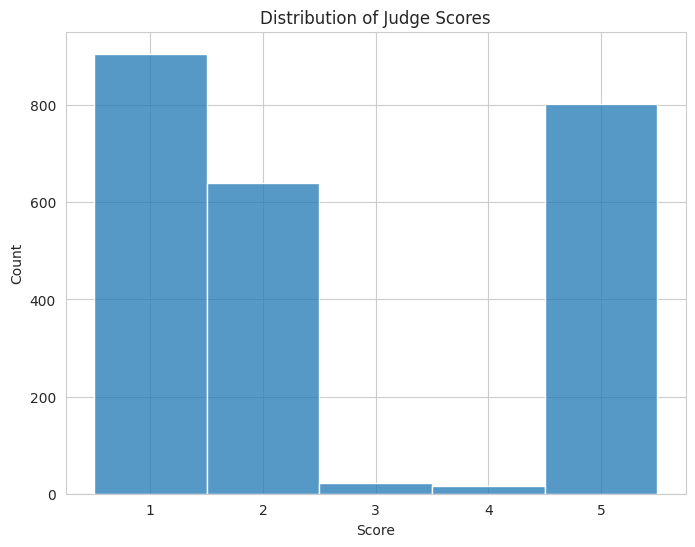

In [189]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


# Loading evaluation on 5 frames

In [51]:
judge_pred_df_50samples = judge_pred_df


## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [52]:
# Load the scores for the wrong answers
predictions = []
with open(WORK_DIR / "cvrr/cvrr_val_judge_evaluation.jsonl", 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 37.5+ KB


## Handle formatting issues

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [53]:

# Create mask for answers that follow JSON syntax
json_mask = judge_pred_df['response'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(judge_pred_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(judge_pred_df))*100:.2f}%")


Total answers: 2400
Answers following JSON template: 2392
Percentage following JSON template: 99.67%


In [54]:
judge_pred_df.loc[json_mask, 'response'] = \
    judge_pred_df.loc[json_mask, 'response'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

judge_pred_df.loc[~json_mask, 'response'] = ""
judge_pred_df = judge_pred_df.loc[json_mask]
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2392 non-null   object
dtypes: object(1)
memory usage: 37.4+ KB


In [55]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u2018-\u201b]', '\'', regex=True)
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"reason\": \")(.*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['response']),
        axis=1
        )


In [56]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*\})(.*)", 
            r"\1", 
            row['response']),
        axis=1
        )
    
# some times the model starts the answer with \" but then terminates it with \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\"(.*)\'\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )
    
# some times the model starts the answer with \' but then terminates it with \"
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\'(.*)\"\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )

    
# some times the model is enclosed by \' \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(?<=\'reason\':)\s+\'(.*)\'\s*(?=})", 
            lambda matchobj: "\"" + matchobj.group(1)+ "\"", 
            row['response']),
        axis=1
        )
    


# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(\'reason\':\s*\")(.*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', ''), 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2392 non-null   object
dtypes: object(1)
memory usage: 37.4+ KB


## Extract answers

In [57]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,2,The predicted answer incorrectly states the go...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the i...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The predicted answer provides a detailed break...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer provides a detailed break...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,2,The ground truth states the woman is performin...


In [58]:
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,2,The predicted answer incorrectly states the go...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the i...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The predicted answer provides a detailed break...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer provides a detailed break...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,2,The ground truth states the woman is performin...


In [59]:
judge_pred_df.shape


(2392, 3)

# Metric values

In [69]:
judge_pred_df[['video_id', 'n_frames']] = cvrr_dataset_df[['video_id', 'n_frames']]
judge_pred_df[judge_pred_df['n_frames'] > 30].shape


(455, 5)

In [62]:
min_frames = 5
pred_percentages = judge_pred_df[judge_pred_df['n_frames'] > min_frames]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  58.21%
correct   :  41.79%
------------------------------


In [75]:
n_frames = [i for i in range(0, 31, 5)]
data_points_size = []
acc_vals = []

for frames in n_frames:
    mask = judge_pred_df['n_frames'] > frames
    data_points_size.append(mask.sum())
    
    pred_percentages = judge_pred_df[mask]['pred'].value_counts(normalize=True)
    acc_vals.append(pred_percentages['correct'])


In [70]:
acc_vals_50 = []

for frames in n_frames:
    mask = judge_pred_df_50samples['n_frames'] > frames

    pred_percentages = judge_pred_df_50samples[mask]['pred'].value_counts(normalize=True)
    acc_vals_50.append(pred_percentages['correct'])


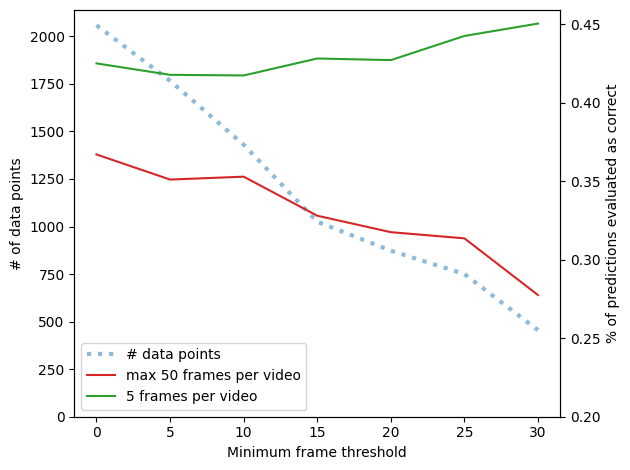

In [117]:
_, ax1 = plt.subplots()

# Beautiful seaborn-inspired colors
primary_color = 'tab:blue'    # Deep blue - very pleasing to the eye
secondary_color = 'tab:red'   # For first line on secondary axis
tertiary_color = 'tab:green'  # For second line on secondary axis (added new color)

# Primary axis (left)
ax1.set_xlabel("Minimum frame threshold")
ax1.set_ylabel("# of data points")
line0 = ax1.plot(n_frames, data_points_size, color=fst_color, label='# data points',  linestyle=':', linewidth=3, alpha=0.5)
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

# Secondary axis (right)
ax2 = ax1.twinx()
ax2.set_ylabel("% of predictions evaluated as correct")

# Plot both lines on the secondary axis
line1 = ax2.plot(n_frames, acc_vals_50, color=secondary_color, label='max 50 frames per video')
line2 = ax2.plot(n_frames, acc_vals, color=tertiary_color, label='5 frames per video')  # Add your actual threshold here

ax2.tick_params(axis='y')  # Don't need labelcolor if both lines use the same axis
ax2.set_ylim(bottom=.2)

# Add legend to distinguish the two lines on the secondary axis
lines = line0 + line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='lower left')

plt.tight_layout()
plt.show()


# Load Judge evaluation with our prompt

In [82]:
judge_pred_df_5samples = judge_pred_df


## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [83]:
# Load the scores for the wrong answers
predictions = []
with open(WORK_DIR / "cvrr/our_judge_eval_maxsample50.jsonl", 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 37.5+ KB


## Handle formatting issues

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [84]:

# Create mask for answers that follow JSON syntax
json_mask = judge_pred_df['response'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(judge_pred_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(judge_pred_df))*100:.2f}%")


Total answers: 2400
Answers following JSON template: 2199
Percentage following JSON template: 91.62%


In [85]:
judge_pred_df.loc[json_mask, 'response'] = \
    judge_pred_df.loc[json_mask, 'response'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

judge_pred_df.loc[~json_mask, 'response'] = ""
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [86]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u2018-\u201b]', '\'', regex=True)
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u201c\u201d]', '"', regex=True)


In [87]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*?\})", 
            r"\1", 
            row['response']),
        axis=1
        )


In [88]:
test = judge_pred_df.iloc[1320]["response"]
print(test)


{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 1}


In [89]:
# # unbalanced quotes test
pattern = rf"[\'\"](reason)[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2))\s*(,)?\s*[\"\']pred..(?!$)"
#pattern = rf"[\'\"](reason)[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2)(,)?\s*)(?=[\'\"]pred..)(?!$)"
re.findall(
    pattern,
    test
)


[('reason',
  '"',
  'The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\',
  '',
  '')]

In [90]:
subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + "\", \'pred\'",
            test)
print(subbed)


{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \", 'pred': \"incorrect\", \"score\": 1}


In [91]:
def adjust_unbalanced_quotes(text):
    fields = ['reason', 'pred', 'score']
    for i in range(len(fields)-1):
        field = fields[i]
        delimiter = rf"{fields[i+1]}"

        # (?<!<txt>): negative look-behind assert. current position in the string is not preceed by <txt> 
        pattern = rf"[\'\"]({field})[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2))\s*(,)?\s*[\'\"]{fields[i+1]}..(?!$)"
        subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + f"\", \'{fields[i+1]}\'",
            text)
        return subbed
    

test_o = adjust_unbalanced_quotes(test)
print(repr(test_o))
#eval(test_o)


'{\'reason\': "The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\", \'pred\': \\"incorrect\\", \\"score\\": 1}'


In [92]:
# single quotes test
pattern = r"[\"\']reason[\'\"]:\s+\'(.*)\'\s*(?=,\s*[\"\']pred)"
re.findall(
    pattern,
    test_o
)


[]

In [93]:
# # unescaped doublequotes test
inside_doublequotes = r"([\"\']reason[\"\']:\s*\")(.*\".*)\"\s*(?=,\s*[\"\']pred)"

re.findall(
    inside_doublequotes,
    test_o
)



[('\'reason\': "',
  'The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\')]

In [94]:
test_o = re.sub(
    inside_doublequotes, 
    lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', '\'') + "\"", 
    test)

print(repr(test_o))
# eval(test_o)


'{\'reason\': "The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\"pred\\": \\"incorrect\\", \\"score\\": 1}'


In [95]:
# Adgust fields that are only-half quoted (no end quote) or mismatching quotes


def adjust_unbalanced_quotes(text):
    fields = ['reason', 'pred', 'score']
    for i in range(len(fields)-1):
        field = fields[i]
        delimiter = rf"(?:,\s*[\"\']{fields[i+1]})"

        # (?<!<txt>): negative look-behind assert. current position in the string is not preceed by <txt> 
        pattern = rf"[\'\"]({field})[\'\"]:\s*([\"\'])(.*?)(?=(?<!(?<!\\)\2){delimiter})(?!$)"
        subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + "\"",
            text)
        return subbed
    
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: adjust_unbalanced_quotes(row['response']),
        axis=1
        )


In [96]:
eval(judge_pred_df.iloc[1211]["response"])


{'reason': 'The given answer states, "No, the interaction with the mobile phone occurs after drinking." However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.',
 'pred': 'incorrect',
 'score': 1}

In [97]:
# some times the model is enclosed by \' \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"[\"\']reason[\'\"]:\s+\'(.*)\'\s*(?=,\s*[\"\']pred)", 
            lambda matchobj: "\'reason\': \"" + matchobj.group(1)+ "\"", 
            row['response']),
        axis=1
        )


In [98]:
eval(judge_pred_df.iloc[1211]['response'])


{'reason': 'The given answer states, "No, the interaction with the mobile phone occurs after drinking." However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.',
 'pred': 'incorrect',
 'score': 1}

In [99]:
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason parameter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"([\"\']reason[\"\']:\s*\")(.*\".*)\"\s*(?=,\s*[\"\']pred)"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', '\'') + "\"", 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [100]:
eval(judge_pred_df.iloc[1211]['response'])


{'reason': "The given answer states, 'No, the interaction with the mobile phone occurs after drinking.' However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.",
 'pred': 'incorrect',
 'score': 1}

In [101]:
judge_pred_df = judge_pred_df.loc[json_mask]
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2199 non-null   object
dtypes: object(1)
memory usage: 34.4+ KB


In [102]:
for i in range(judge_pred_df.shape[0]):
    try:
        pr = judge_pred_df.iloc[i]["response"]
        if(pr == ''):
            continue
        eval(pr)
    except:
        print(i)
        print(pr)


1211
{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 1}
1919
{   "reason": "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question you want me to answer.\" does not provide any specific actions the woman takes to express her frustration. It simply states the assistant's readiness to analyze the scene graph. This is a completely irrelevant response to the question. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 0}
1972
{'reason': "The given answer states: \"Based on the provided scene graph, the prank depicted in the video appears to 

In [103]:
# remove difficult to adjust lines:
hard = [1211, 1919, 1972, 2156]
judge_pred_df = judge_pred_df.drop(judge_pred_df.iloc[hard].index)



## Extract answers

In [104]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,1,"The given answer states: 'Therefore, the red_s..."
b27163c5-d341-475b-8517-54809872081a,correct,5,The given answer 'Based on the provided scene ...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,3,The given answer states 'There are a total of ...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The given answer states: 'The golden hollow sp...
01c30c62-f489-4246-af18-b7b538b4cb9d,incorrect,2,The given answer states 'There are a total of ...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,"The given answer states, 'The video does not s..."
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,2,The given answer provides a detailed descripti...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,1,The given answer states: 'The woman is using a...


In [105]:
judge_pred_df.shape


(2195, 3)

In [106]:
judge_pred_df[['video_id', 'n_frames']] = cvrr_dataset_df[['video_id', 'n_frames']]
judge_pred_df[judge_pred_df['n_frames'] > 30].shape


(404, 5)

# Metric values

In [107]:
min_frames = 5
pred_percentages = judge_pred_df[judge_pred_df['n_frames'] > min_frames]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  72.70%
correct   :  27.30%
------------------------------


In [109]:
acc_vals_50_our_prompt = []

for frames in n_frames:
    mask = judge_pred_df['n_frames'] > frames

    pred_percentages = judge_pred_df[mask]['pred'].value_counts(normalize=True)
    acc_vals_50_our_prompt.append(pred_percentages['correct'])


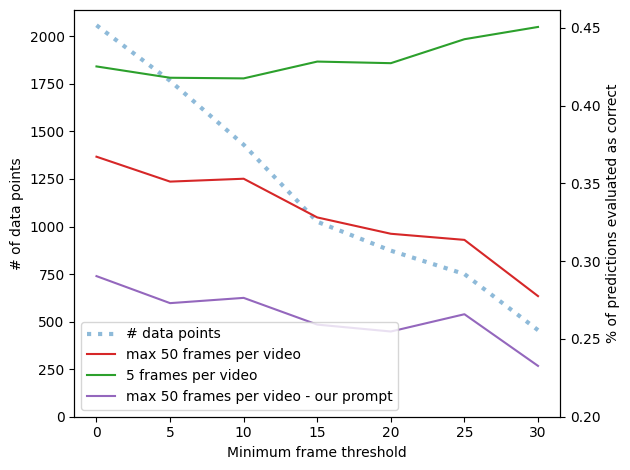

In [116]:
_, ax1 = plt.subplots()

# Beautiful seaborn-inspired colors
fst_color = 'tab:blue'    # Deep blue - very pleasing to the eye
snd_color = 'tab:red'   # For first line on secondary axis
trd_color = 'tab:green'  # For second line on secondary axis (added new color)
fth_color = 'tab:purple'

# Primary axis (left)
ax1.set_xlabel("Minimum frame threshold")
ax1.set_ylabel("# of data points")
line0 = ax1.plot(n_frames, data_points_size, color=fst_color, label='# data points',  linestyle=':', linewidth=3, alpha=0.5)
ax1.tick_params(axis='y')
ax1.set_ylim(bottom=0)

# Secondary axis (right)
ax2 = ax1.twinx()
ax2.set_ylabel("% of predictions evaluated as correct")

# Plot both lines on the secondary axis
line1 = ax2.plot(n_frames, acc_vals_50, color=snd_color, label='max 50 frames per video')
line2 = ax2.plot(n_frames, acc_vals, color=trd_color, label='5 frames per video')  # Add your actual threshold here
line3 = ax2.plot(n_frames, acc_vals_50_our_prompt, color=fth_color, label='max 50 frames per video - our prompt')

ax2.tick_params(axis='y')  # Don't need labelcolor if both lines use the same axis
ax2.set_ylim(bottom=.2)

# Add legend to distinguish the two lines on the secondary axis
lines = line0 + line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='lower left')

plt.tight_layout()
plt.show()
